## Introduction

This notebook describes the analysis of extracellular recording data from Loren Frank Lab. The data was downloaded from CRNS website ( https://portal.nersc.gov/project/crcns/download/hc-6 ). These are tetrode recordings from the medial Entorhinal Corectex (mEC) and hippocampus of male rats. I have plans to understand coherence in certain freequency intervals from the LFP traces and we will look into spiking of units/cells related to spatial aspects of the experiments and temporal aspects of the Local Field Potential (LFP) recordings.  

In [4]:
import numpy as np
from numpy.fft import rfft
import scipy.io
from scipy import signal
from neurodsp.spectral import compute_spectrum, rotate_powerlaw

# Import utilities for loading and plotting data
from neurodsp.utils import create_times
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series
from neurodsp.filt import filter_signal

import matplotlib.pyplot as plt
%matplotlib inline

On the 9th day, 4th block (rat was on one of the two w-sized tracks) of the experiments, the rat named Five was alternating between the two border legs of the track as we can see from the position traces below. 

In [5]:
pos = np.genfromtxt("g:/Arun/neural_data/hc-6/Fiv/processed_data/FivePos09_04.csv", delimiter=",")

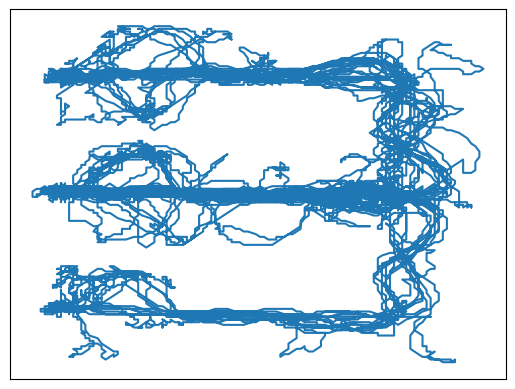

In [9]:
fig = plt.figure()
plt.plot(pos[:,1], pos[:,2])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)